In [2]:
import pandas as pd
import numpy as np
import function_utils as utils

In [2]:
residuals = pd.read_csv("../Residualised_healthycontrol_training_all.csv")

In [3]:
healthy_controls = pd.read_csv("../Training_residualsealthycontrol_healthycontrol.csv")

In [4]:
neurodegenerative_controls = pd.read_csv("../Training_residualshealthycontrol_neurodegenerative.csv")

In [5]:
from scipy.stats import mannwhitneyu
import pandas as pd

# Get list of protein columns (excluding eid and Diagnosis)
protein_cols = neurodegenerative_controls.columns.difference(['eid', 'Diagnosis'])

# Prepare results list
results = []

# Loop through each protein
for protein in protein_cols:
    group_0 = neurodegenerative_controls[neurodegenerative_controls['Diagnosis'] == 0][protein].dropna()
    group_1 = neurodegenerative_controls[neurodegenerative_controls['Diagnosis'] == 1][protein].dropna()
    
    # Perform Mann-Whitney U test only if both groups have enough values
    if len(group_0) > 5 and len(group_1) > 5:
        stat, p_value = mannwhitneyu(group_0, group_1, alternative='two-sided')
        results.append({'Protein': protein, 'U_statistic': stat, 'p_value': p_value})
    else:
        results.append({'Protein': protein, 'U_statistic': None, 'p_value': None})

# Convert to DataFrame
mw_df = pd.DataFrame(results)

# Add FDR correction if needed
from statsmodels.stats.multitest import multipletests
mw_df['p_adj'] = multipletests(mw_df['p_value'], method='bonferroni')[1]

# Sort by adjusted p-value
mw_df = mw_df.sort_values(by='p_adj')


In [6]:
significant_neurodegenerative = mw_df[mw_df["p_adj"] <0.05]

In [7]:
from scipy.stats import mannwhitneyu
import pandas as pd

# Get list of protein columns (excluding eid and Diagnosis)
protein_cols = healthy_controls.columns.difference(['eid', 'Diagnosis'])

# Prepare results list
results_hc = []

# Loop through each protein
for protein in protein_cols:
    group_0 = healthy_controls[healthy_controls['Diagnosis'] == 0][protein].dropna()
    group_1 = healthy_controls[healthy_controls['Diagnosis'] == 1][protein].dropna()
    
    # Perform Mann-Whitney U test only if both groups have enough values
    if len(group_0) > 5 and len(group_1) > 5:
        stat, p_value = mannwhitneyu(group_0, group_1, alternative='two-sided')
        results_hc.append({'Protein': protein, 'U_statistic': stat, 'p_value': p_value})
    else:
        results_hc.append({'Protein': protein, 'U_statistic': None, 'p_value': None})

# Convert to DataFrame
mw_df_healthy = pd.DataFrame(results_hc)

# Add FDR correction if needed
from statsmodels.stats.multitest import multipletests
mw_df_healthy['p_adj'] = multipletests(mw_df_healthy['p_value'], method='bonferroni')[1]

# Sort by adjusted p-value
mw_df_healthy = mw_df_healthy.sort_values(by='p_adj')


In [8]:
significant_hc = mw_df_healthy[mw_df_healthy["p_adj"] <0.05]

In [9]:
significant_neurodegenerative["Protein"].nunique()

significant_hc["Protein"].nunique()

122

In [10]:
median_diffs = []

for protein in mw_df['Protein']:
    median_1 = neurodegenerative_controls[neurodegenerative_controls['Diagnosis'] == 1][protein].median()
    median_0 = neurodegenerative_controls[neurodegenerative_controls['Diagnosis'] == 0][protein].median()
    median_diffs.append(median_1 - median_0)

mw_df['median_diff'] = median_diffs


In [11]:
median_diffs_healthy = []

for protein in mw_df_healthy['Protein']:
    median_1 = healthy_controls[healthy_controls['Diagnosis'] == 1][protein].median()
    median_0 = healthy_controls[healthy_controls['Diagnosis'] == 0][protein].median()
    median_diffs_healthy.append(median_1 - median_0)

mw_df_healthy['median_diff'] = median_diffs_healthy


In [12]:
proteins_healthy = mw_df_healthy[mw_df_healthy["p_adj"] < 0.05]["Protein"].unique().tolist()

In [13]:
# Write to a file
with open("proteins_residuals_PD_HC_residualisedhealthycontrol_list.txt", "w") as f:
    for protein in proteins_healthy:
        f.write(protein + "\n")

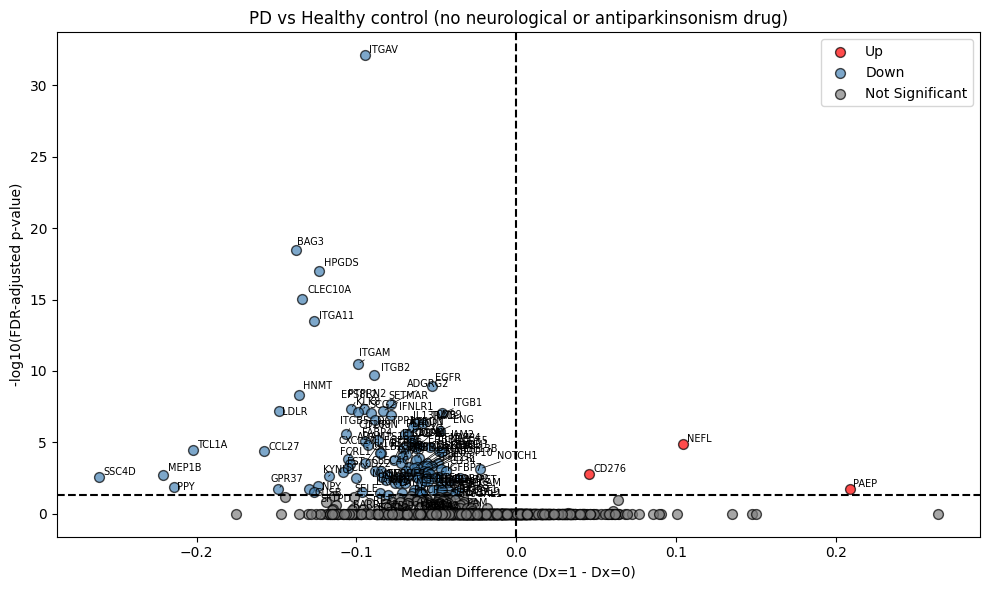

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

def assign_significance(row):
    if row['p_adj'] < 0.05:
        return 'Up' if row['median_diff'] > 0 else 'Down'
    else:
        return 'Not Significant'

# Assign categories
mw_df_healthy['significance'] = mw_df_healthy.apply(assign_significance, axis=1)
mw_df_healthy['neg_log10_p'] = -np.log10(mw_df_healthy['p_adj'])

# Plot
plt.figure(figsize=(10, 6))
colors = {"Up": "red", "Down": "steelblue", "Not Significant": "grey"}

for label, color in colors.items():
    subset = mw_df_healthy[mw_df_healthy['significance'] == label]
    plt.scatter(
        subset['median_diff'],
        subset['neg_log10_p'],
        label=label,
        color=color,
        alpha=0.7,
        edgecolors="k",
        s=50
    )

# Axes reference lines
plt.axhline(-np.log10(0.05), linestyle="--", color="black")
plt.axvline(0, linestyle="--", color="black")

# Annotate significant proteins
texts = []
top_sig = mw_df_healthy[mw_df_healthy['significance'] != "Not Significant"]

for _, row in top_sig.iterrows():
    texts.append(
        plt.text(row['median_diff'], row['neg_log10_p'], row['Protein'], fontsize=7)
    )

adjust_text(texts, arrowprops=dict(arrowstyle="-", color="black", lw=0.5))

# Labels and title
plt.xlabel("Median Difference (Dx=1 - Dx=0)")
plt.ylabel("-log10(FDR-adjusted p-value)")
plt.legend()
plt.title("PD vs Healthy control (no neurological or antiparkinsonism drug)")
plt.tight_layout()
plt.show()


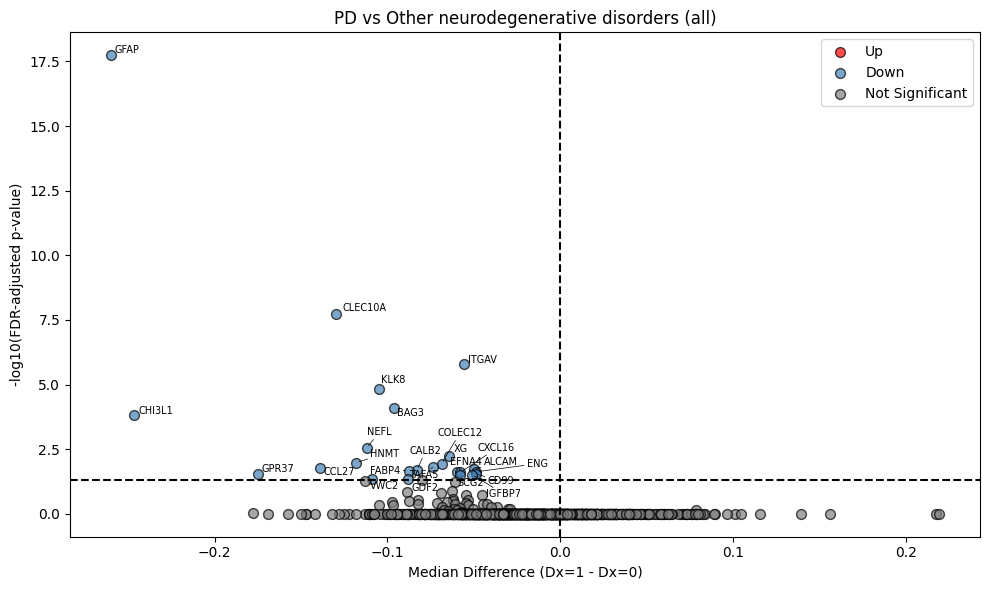

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

def assign_significance(row):
    if row['p_adj'] < 0.05:
        return 'Up' if row['median_diff'] > 0 else 'Down'
    else:
        return 'Not Significant'

# Assign significance categories
mw_df['significance'] = mw_df.apply(assign_significance, axis=1)
mw_df['neg_log10_p'] = -np.log10(mw_df['p_adj'])

# Plot
plt.figure(figsize=(10, 6))
colors = {"Up": "red", "Down": "steelblue", "Not Significant": "grey"}

for label, color in colors.items():
    subset = mw_df[mw_df['significance'] == label]
    plt.scatter(
        subset['median_diff'],
        subset['neg_log10_p'],
        label=label,
        color=color,
        alpha=0.7,
        edgecolors="k",
        s=50
    )

# Axes reference lines
plt.axhline(-np.log10(0.05), linestyle="--", color="black")
plt.axvline(0, linestyle="--", color="black")

# Annotate significant proteins (FDR < 0.05)
texts = []
top_sig = mw_df[mw_df['significance'] != "Not Significant"]

for _, row in top_sig.iterrows():
    texts.append(
        plt.text(row['median_diff'], row['neg_log10_p'], row['Protein'], fontsize=7)
    )

adjust_text(texts, arrowprops=dict(arrowstyle="-", color="black", lw=0.5))

# Labels and style
plt.xlabel("Median Difference (Dx=1 - Dx=0)")
plt.ylabel("-log10(FDR-adjusted p-value)")
plt.legend()
plt.title("PD vs Other neurodegenerative disorders (all)")
plt.tight_layout()
plt.show()


In [16]:
proteins_neuro = mw_df[mw_df["p_adj"] < 0.05]["Protein"].unique().tolist()

In [17]:
proteins_hc_ond= set(proteins_neuro) | set(proteins_healthy)

In [18]:
# Write to a file
with open("proteins_residuals_PD_HC_PD_OND_residualisedhealthycontrol_list.txt", "w") as f:
    for protein in proteins_hc_ond:
        f.write(protein + "\n")

In [19]:
controls = healthy_controls[healthy_controls["Diagnosis"] ==0]
neurodegenerative = neurodegenerative_controls[neurodegenerative_controls["Diagnosis"] ==0]
neurodegenerative["Diagnosis"] =1

/var/tmp/pbs.1006376.pbs-7/ipykernel_1935970/26665368.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neurodegenerative["Diagnosis"] =1


In [20]:
controlsvsneuro = pd.concat([controls, neurodegenerative])

In [21]:
from scipy.stats import mannwhitneyu
import pandas as pd

# Get list of protein columns (excluding eid and Diagnosis)
protein_cols = controlsvsneuro.columns.difference(['eid', 'Diagnosis'])

# Prepare results list
results_controlsvsneuro= []

# Loop through each protein
for protein in protein_cols:
    group_0 = controlsvsneuro[controlsvsneuro['Diagnosis'] == 0][protein].dropna()
    group_1 = controlsvsneuro[controlsvsneuro['Diagnosis'] == 1][protein].dropna()
    
    # Perform Mann-Whitney U test only if both groups have enough values
    if len(group_0) > 5 and len(group_1) > 5:
        stat, p_value = mannwhitneyu(group_0, group_1, alternative='two-sided')
        results_controlsvsneuro.append({'Protein': protein, 'U_statistic': stat, 'p_value': p_value})
    else:
        results_controlsvsneuro.append({'Protein': protein, 'U_statistic': None, 'p_value': None})

# Convert to DataFrame
mw_df_neurocontrols = pd.DataFrame(results_controlsvsneuro)

# Add FDR correction if needed
from statsmodels.stats.multitest import multipletests
mw_df_neurocontrols['p_adj'] = multipletests(mw_df_neurocontrols['p_value'], method='bonferroni')[1]

# Sort by adjusted p-value
mw_df_neurocontrols = mw_df_neurocontrols.sort_values(by='p_adj')


In [22]:
significant_neurocontrols = mw_df_neurocontrols[mw_df_neurocontrols["p_adj"] <0.05]

In [23]:
significant_neurocontrols[significant_neurocontrols["Protein"] == "ITGAV"]

,Protein,U_statistic,p_value,p_adj
763,ITGAV,11718054.0,1.252105e-09,0.000002


In [24]:
median_diffs_neurocontrols = []

for protein in mw_df['Protein']:
    median_1 = controlsvsneuro[controlsvsneuro['Diagnosis'] == 1][protein].median()
    median_0 = controlsvsneuro[controlsvsneuro['Diagnosis'] == 0][protein].median()
    median_diffs_neurocontrols.append(median_1 - median_0)

mw_df_neurocontrols['median_diff'] = median_diffs_neurocontrols


In [25]:
controlsvsneuro["Diagnosis"].value_counts()

0    21128
1      996
Name: Diagnosis, dtype: int64

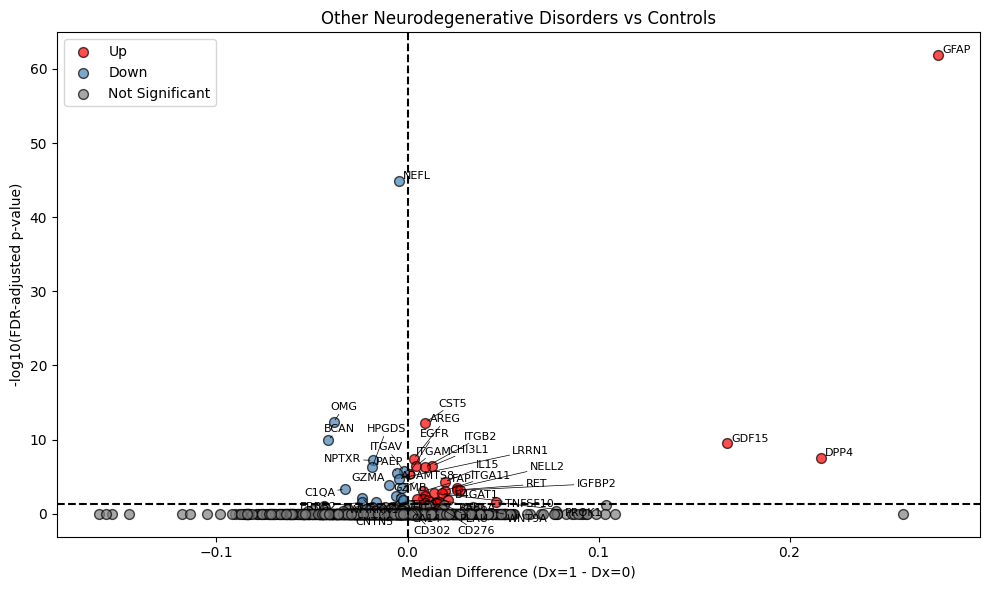

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

def assign_significance(row):
    if row['p_adj'] < 0.05:
        return 'Up' if row['median_diff'] > 0 else 'Down'
    else:
        return 'Not Significant'

# Assign categories
mw_df_neurocontrols['significance'] = mw_df_neurocontrols.apply(assign_significance, axis=1)
mw_df_neurocontrols['neg_log10_p'] = -np.log10(mw_df_neurocontrols['p_adj'])

# Plot
plt.figure(figsize=(10, 6))
colors = {"Up": "red", "Down": "steelblue", "Not Significant": "grey"}

for label, color in colors.items():
    subset = mw_df_neurocontrols[mw_df_neurocontrols['significance'] == label]
    plt.scatter(
        subset['median_diff'],
        subset['neg_log10_p'],
        label=label,
        color=color,
        alpha=0.7,
        edgecolors="k",
        s=50
    )

# Axes reference lines
plt.axhline(-np.log10(0.05), linestyle="--", color="black")
plt.axvline(0, linestyle="--", color="black")

# Annotate top N significant proteins
top_n = 40
sig_df = mw_df_neurocontrols[mw_df_neurocontrols['significance'] != "Not Significant"]
sig_df = sig_df.sort_values(by='p_adj').head(top_n)

texts = []
for _, row in sig_df.iterrows():
    texts.append(
        plt.text(row['median_diff'], row['neg_log10_p'], row['Protein'], fontsize=8)
    )

adjust_text(texts, arrowprops=dict(arrowstyle="-", color="black", lw=0.5))

# Labels and title
plt.xlabel("Median Difference (Dx=1 - Dx=0)")
plt.ylabel("-log10(FDR-adjusted p-value)")
plt.legend()
plt.title("Other Neurodegenerative Disorders vs Controls")
plt.tight_layout()
plt.show()


In [27]:
path_rds_diagnoses = "/rds/general/user/meb22/projects/ukbiobank/live/ukbiobank/data_2025/UKBB_diagnoses_Jun2025/processed/diagnoses_extracted"
pd_df =  pd.read_csv(f"{path_rds_diagnoses}/Parkinson.csv").iloc[:, 1:]


In [28]:
pd_controls_visits = pd.merge(healthy_controls, pd_df[["eid","date_diagnosis"]], on="eid")

In [29]:
visit_dates = pd.read_csv("/rds/general/user/meb22/projects/ukbiobank/live/ukbiobank/data_2025/Visit_dates.csv")

In [30]:
df_dates = pd.merge(pd_controls_visits, visit_dates[["eid","p53_i0"]], on="eid")

In [31]:
import pandas as pd

# Ensure both columns are datetime
df_dates["p53_i0"] = pd.to_datetime(df_dates["p53_i0"])
df_dates["date_diagnosis"] = pd.to_datetime(df_dates["date_diagnosis"])

# Compute difference in days and convert to years
df_dates["time_to_diagnosis"] = (df_dates["date_diagnosis"] - df_dates["p53_i0"]).dt.total_seconds() / (365.25*24*3600)

# Optional: round to 2 decimal places
df_dates["time_to_diagnosis"] = df_dates["time_to_diagnosis"].round(2)

In [32]:
mw_df_healthy[mw_df_healthy["p_value"] < 0.05]["Protein"]

763       ITGAV
110        BAG3
655       HPGDS
298     CLEC10A
759      ITGA11
         ...   
521      FCGR2B
548       FLRT2
527       FCRL5
526       FCRL3
1460     ZBTB17
Name: Protein, Length: 564, dtype: object

In [33]:
mw_df_neurocontrols[mw_df_neurocontrols["p_value"] <0.05]["Protein"]

585       GFAP
957       NEFL
1006       OMG
369       CST5
117       BCAN
         ...  
496      ERP44
516      FASLG
503         F7
499        EZR
1460    ZBTB17
Name: Protein, Length: 351, dtype: object

In [34]:
# Make sure both have consistent significance labels
def assign_significance(row):
    if row['p_adj'] < 0.05:
        return 'Up' if row['median_diff'] > 0 else 'Down'
    else:
        return 'Not Significant'

mw_df_healthy['significance'] = mw_df_healthy.apply(assign_significance, axis=1)
mw_df_neurocontrols['significance'] = mw_df_neurocontrols.apply(assign_significance, axis=1)

# Merge on protein names
merged = mw_df_healthy[['Protein', 'significance']].merge(
    mw_df_neurocontrols[['Protein', 'significance']],
    on='Protein',
    how='left',
    suffixes=('_healthy', '_neuro')
)

# Keep only those significant in healthy AND not matching direction in neurocontrols
unique_to_healthy = merged[
    (merged['significance_healthy'].isin(['Up', 'Down'])) &
    (merged['significance_healthy'] != merged['significance_neuro'])
]

same_healthy_ond = merged[
    (merged['significance_healthy'].isin(['Up', 'Down'])) &
    (merged['significance_healthy'] == merged['significance_neuro'])
]


# Subset original df for details
mw_df_healthy_unique = mw_df_healthy[mw_df_healthy['Protein'].isin(unique_to_healthy['Protein'])]

print(mw_df_healthy_unique.shape)


(116, 7)


In [35]:
unique_PD_HC_list = mw_df_healthy_unique["Protein"].unique().tolist()

In [36]:
proteins_pdhc_unique_pdond = proteins_hc_ond - set(same_healthy_ond["Protein"].unique().tolist())

In [37]:
# Write to a file
with open("proteins_residuals_PD_HC_unique_PD_OND_residualisedhealthycontrol_list.txt", "w") as f:
    for protein in proteins_pdhc_unique_pdond:
        f.write(protein + "\n")